In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd 
import numpy as np
import itertools
import glob
import re
import logging

from textblob import TextBlob
from wordcloud import WordCloud
from pprint import pprint
from time import time

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import linear_model

/Users/hesamparsa/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/hesamparsa/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
path1='/Users/hesamparsa/Dropbox/job application/Data_Science/Insight/sexting/SMSSpamCollection.txt'
path2='/Users/hesamparsa/Dropbox/job application/Data_Science/Insight/sexting/sextlist.txt'

In [3]:
sms1 = pd.read_table(path1, header=None, names=['label', 'message'])  # UCI machine learning Repository
sms2 = pd.read_table(path2, header=None, names=['label', 'message'])  # My online search for sexts
sms = sms1.append(sms2,  ignore_index=True)
sms.message.replace(to_replace='[\d\.\?]', value='',inplace= True, regex=True)
sms=sms[(sms.label =='ham')  | (sms.label =='spam') | (sms.label =='sexpam')]

In [4]:
sms['label_num'] = sms.label.map({'ham':0, 'spam':1, 'sexpam':2})

In [53]:
sms.label_num.value_counts()

0    4825
1     747
2     459
Name: label_num, dtype: int64

In [5]:
# Vectorizing the SMS data
X = sms.message
y = sms.label_num
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
vect = CountVectorizer()  # ngram_range=(1,2), min_df=20, max_df=0.5
modeling_fcn(vect)

NameError: name 'modeling_fcn' is not defined

In [6]:
def modeling_fcn(vect):
    
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    
    # print the number of features that were generated
    print('Features: ', X_train_dtm.shape[1])
    
    # use a model (e.g. Multinomial Naive Bayes) to predict the star rating
    clf = linear_model.SGDClassifier()
    #clf = MultinomialNB()
    clf.fit(X_train_dtm, y_train)
    y_pred_class = clf.predict(X_test_dtm)
    
    # print the accuracy of its predictions
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred_class)
    
    print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))
    #print ('Confusion matrix:', cnf_matrix)
    # Compute confusion matrix
    # Plot non-normalized confusion matrix
    plt.figure()
    class_names = ['ham', 'spam', 'sexpam' ]
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
    plt.show()

In [8]:
# calculate null accuracy
print('null accuracy:', y_test.value_counts().head(1) / y_test.shape)

null accuracy: 0    0.809019
Name: label_num, dtype: float64


Features:  7227
Accuracy:  0.928381962865
Confusion matrix, without normalization
[[1167   17   36]
 [  17  165    0]
 [  38    0   68]]


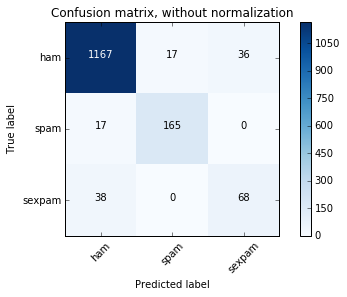

In [102]:
# TfidfVectorizer (CountVectorizer + TfidfTransformer)
X = sms.message
y = sms.label_num
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
vect = TfidfVectorizer()  # this parameter will increase the norm=None
modeling_fcn(vect)

In [90]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__n_iter': (10, 50, 80),
}

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 3456 out of 3456 | elapsed: 12.7min finished


Best score: 0.946
	clf__alpha: 1e-05
	clf__n_iter: 10
	clf__penalty: 'elasticnet'
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.75
	vect__max_features: None
	vect__ngram_range: (1, 2)
Confusion matrix, without normalization
[[1220    0    0]
 [   0  182    0]
 [   0    0  106]]


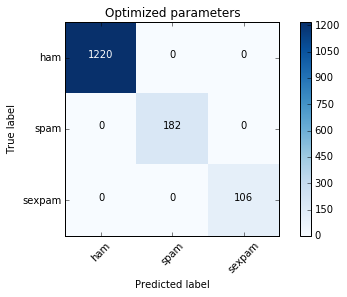

In [112]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
grid_search.fit(X, y)
print("Best score: %0.3f" % grid_search.best_score_)
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

y_pred_class = grid_search.best_estimator_.predict(X_test)

# Plot non-normalized confusion matrix
plt.figure()
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_class)
class_names = ['ham', 'spam', 'sexpam']
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Optimized parameters')
plt.show()

In [103]:
# Sentiment analysis
sms['sentiment_polarity'] = sms.message.apply(detect_sentiment_polarity)
sms['sentiment_subjectivity'] = sms.message.apply(detect_sentiment_subjectivity)

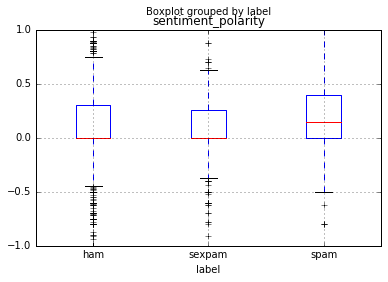

In [104]:
sms.boxplot('sentiment_polarity', by='label')

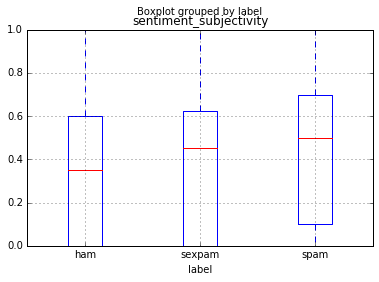

In [105]:
sms.boxplot('sentiment_subjectivity', by='label')  

Accuracy:  0.807692307692
Confusion matrix, without normalization
[[1166   41   13]
 [ 135   47    0]
 [  98    3    5]]


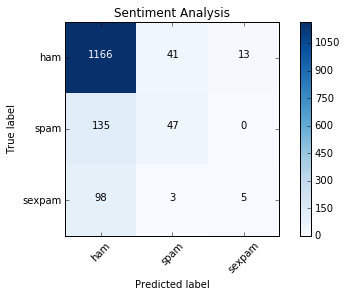

In [118]:
feature_cols = ['sentiment_polarity','sentiment_subjectivity' ]
Xn = sms[feature_cols]
yn = sms.label_num
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, yn, random_state=1)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(Xn_train, yn_train)
yn_pred_class = knn.predict(Xn_test)
print('Accuracy: ', metrics.accuracy_score(yn_test, yn_pred_class))
#print ('Confusion matrix:', metrics.confusion_matrix(yn_test, yn_pred_class))
# Plot non-normalized confusion matrix
plt.figure()
cnf_matrix = metrics.confusion_matrix(yn_test, yn_pred_class)
class_names = ['ham', 'spam', 'sexpam' ]
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Sentiment Analysis')
plt.show()

In [10]:
def detect_sentiment_polarity(text):   
    blob = TextBlob(text)   
    return blob.sentiment.polarity 
    
def detect_sentiment_subjectivity(text):   
    blob = TextBlob(text)   
    return blob.sentiment.subjectivity 

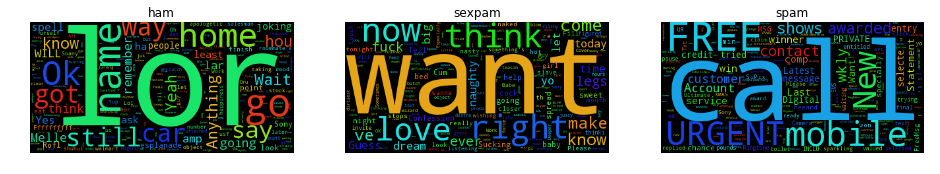

In [38]:
fig = plt.figure(figsize=(16,12))
categories = ['ham', 'sexpam', 'spam']
for i in range(0,len(categories)):
    wordcloud = WordCloud().generate(str(sms.message[sms.label == categories[i]]))
    a=fig.add_subplot(1,3,i+1)
    imgplot = plt.imshow(wordcloud)
    a.set_title(categories[i])
    plt.axis("off")

In [68]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')